In [2]:
import pandas as pd
import numpy as np
import math, random
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
def nCr(n, r):
    f = math.factorial
    return f(n)/f(r)/f(n-r)

In [15]:
from scipy.misc import comb

In [16]:
def ensemble_error(n, epsilon):
    """Error rate of a majority voting ensemble with independent error rate epsilon."""
    return np.sum([comb(n, k)*epsilon**k*(1-epsilon)**(n-k) for k in range(n//2+1, n+1)])

In [17]:
print ensemble_error(20, 0.25)

0.00394214166408


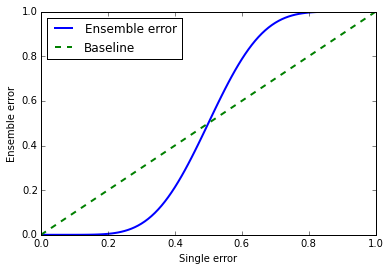

In [19]:
erange = np.arange(0.0, 1.01, 0.01)
ens_errors = [ensemble_error(n=15, epsilon=error) for error in erange]
plt.plot(erange, ens_errors, label='Ensemble error', linewidth=2)
plt.plot(erange, erange, linestyle='--', label='Baseline', linewidth=2)
plt.legend(loc='best')
plt.xlabel("Single error")
plt.ylabel("Ensemble error")
plt.show()

In [20]:
from sklearn.base import BaseEstimator, ClassifierMixin,clone
from sklearn.preprocessing import LabelEncoder
from sklearn.externals import six
from sklearn.pipeline import _name_estimators
import operator

In [21]:
class MajorityVoteClassifier(BaseEstimator, 
                             ClassifierMixin):
    """ A majority vote ensemble classifier

    Parameters
    ----------
    classifiers : array-like, shape = [n_classifiers]
      Different classifiers for the ensemble

    vote : str, {'classlabel', 'probability'} (default='label')
      If 'classlabel' the prediction is based on the argmax of
        class labels. Else if 'probability', the argmax of
        the sum of probabilities is used to predict the class label
        (recommended for calibrated classifiers).

    weights : array-like, shape = [n_classifiers], optional (default=None)
      If a list of `int` or `float` values are provided, the classifiers
      are weighted by importance; Uses uniform weights if `weights=None`.

    """
    def __init__(self, classifiers, vote='classlabel', weights=None):

        self.classifiers = classifiers
        self.named_classifiers = {key: value for key, value
                                  in _name_estimators(classifiers)}
        self.vote = vote
        self.weights = weights

    def fit(self, X, y):
        """ Fit classifiers.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        y : array-like, shape = [n_samples]
            Vector of target class labels.

        Returns
        -------
        self : object

        """
        if self.vote not in ('probability', 'classlabel'):
            raise ValueError("vote must be 'probability' or 'classlabel'"
                             "; got (vote=%r)"
                             % self.vote)

        if self.weights and len(self.weights) != len(self.classifiers):
            raise ValueError('Number of classifiers and weights must be equal'
                             '; got %d weights, %d classifiers'
                             % (len(self.weights), len(self.classifiers)))

        # Use LabelEncoder to ensure class labels start with 0, which
        # is important for np.argmax call in self.predict
        self.lablenc_ = LabelEncoder()
        self.lablenc_.fit(y)
        self.classes_ = self.lablenc_.classes_
        self.classifiers_ = []
        for clf in self.classifiers:
            fitted_clf = clone(clf).fit(X, self.lablenc_.transform(y))
            self.classifiers_.append(fitted_clf)
        return self

    def predict(self, X):
        """ Predict class labels for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Matrix of training samples.

        Returns
        ----------
        maj_vote : array-like, shape = [n_samples]
            Predicted class labels.
            
        """
        if self.vote == 'probability':
            maj_vote = np.argmax(self.predict_proba(X), axis=1)
        else:  # 'classlabel' vote

            #  Collect results from clf.predict calls
            predictions = np.asarray([clf.predict(X)
                                      for clf in self.classifiers_]).T

            maj_vote = np.apply_along_axis(
                                      lambda x:
                                      np.argmax(np.bincount(x,
                                                weights=self.weights)),
                                      axis=1,
                                      arr=predictions)
        maj_vote = self.lablenc_.inverse_transform(maj_vote)
        return maj_vote

    def predict_proba(self, X):
        """ Predict class probabilities for X.

        Parameters
        ----------
        X : {array-like, sparse matrix}, shape = [n_samples, n_features]
            Training vectors, where n_samples is the number of samples and
            n_features is the number of features.

        Returns
        ----------
        avg_proba : array-like, shape = [n_samples, n_classes]
            Weighted average probability for each class per sample.

        """
        probas = np.asarray([clf.predict_proba(X)
                             for clf in self.classifiers_])
        avg_proba = np.average(probas, axis=0, weights=self.weights)
        return avg_proba

    def get_params(self, deep=True):
        """ Get classifier parameter names for GridSearch"""
        if not deep:
            return super(MajorityVoteClassifier, self).get_params(deep=False)
        else:
            out = self.named_classifiers.copy()
            for name, step in six.iteritems(self.named_classifiers):
                for key, value in six.iteritems(step.get_params(deep=True)):
                    out['%s__%s' % (name, key)] = value
            return out

In [22]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.preprocessing import StandardScaler

In [25]:
iris = datasets.load_iris()
X, y = iris.data[50:, [1,2]], iris.target[50:]
le = LabelEncoder()
y = le.fit_transform(y)

In [26]:
xtrain, xtest, ytrain, ytest =train_test_split(X, y, test_size=0.5, random_state=1)

In [28]:
from sklearn.cross_validation import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline

In [29]:
clf1 = LogisticRegression(penalty='l2', C=0.001, random_state=0)
clf2 = DecisionTreeClassifier(max_depth=1, criterion='entropy', random_state=0)
clf3 = KNeighborsClassifier(n_neighbors=1, p=2, metric='minkowski')
pipe1 = Pipeline([['sc', StandardScaler()], ['clf', clf1]])
pipe3 = Pipeline([['sc', StandardScaler()], ['clf', clf3]])
clf_labels = ["Logistic Regression", 'Decision Tree', 'KNN']

In [30]:
print "10-fold cross validation: \n"
for clf, label in zip([pipe1, clf2, pipe3], clf_labels):
    scores = cross_val_score(estimator=clf, X=xtrain, y=ytrain, cv=10, scoring='roc_auc')
    print "ROC AUC: %0.4f (+/- %0.4f) [%s]" %(scores.mean(), scores.std(), label)

10-fold cross validation: 

ROC AUC: 0.9167 (+/- 0.2007) [Logistic Regression]
ROC AUC: 0.9167 (+/- 0.1537) [Decision Tree]
ROC AUC: 0.9333 (+/- 0.1041) [KNN]


In [31]:
mv_clf = MajorityVoteClassifier(classifiers=[pipe1, clf2, pipe3])
clf_labels += ['Majority Voting']
all_clf = [pipe1, clf2, pipe3, mv_clf]
for clf, label in zip(all_clf, clf_labels):
    scores = cross_val_score(estimator=clf, X=xtrain, y=ytrain, cv=10, scoring='roc_auc')
    print "ROC AUC: %0.4f (+/- %0.4f) [%s]" %(scores.mean(), scores.std(), label)

ROC AUC: 0.9167 (+/- 0.2007) [Logistic Regression]
ROC AUC: 0.9167 (+/- 0.1537) [Decision Tree]
ROC AUC: 0.9333 (+/- 0.1041) [KNN]
ROC AUC: 0.9667 (+/- 0.1000) [Majority Voting]


In [32]:
from sklearn.metrics import roc_curve, auc

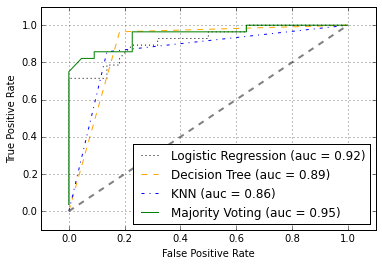

In [33]:
colors = ['black', 'orange', 'blue', 'green']
linestyles = [':', '--', '-.', '-']
for clf, label, clr, ls \
        in zip(all_clf,
               clf_labels, colors, linestyles):

    # assuming the label of the positive class is 1
    y_pred = clf.fit(xtrain,
                     ytrain).predict_proba(xtest)[:, 1]
    fpr, tpr, thresholds = roc_curve(y_true=ytest,
                                     y_score=y_pred)
    roc_auc = auc(x=fpr, y=tpr)
    plt.plot(fpr, tpr,
             color=clr,
             linestyle=ls,
             label='%s (auc = %0.2f)' % (label, roc_auc))

plt.legend(loc='lower right')
plt.plot([0, 1], [0, 1],
         linestyle='--',
         color='gray',
         linewidth=2)

plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.grid()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.show()

In [34]:
from itertools import product


In [35]:
sc = StandardScaler()
X_train_std = sc.fit_transform(xtrain)

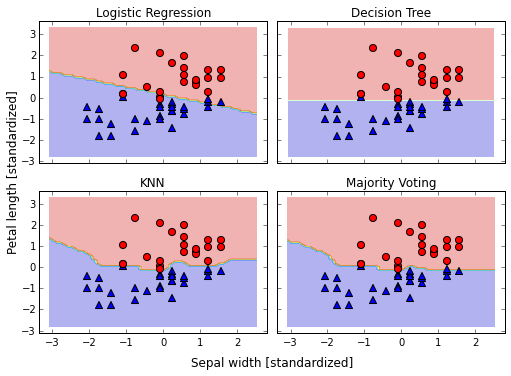

In [39]:
all_clf = [pipe1, clf2, pipe3, mv_clf]

x_min = X_train_std[:, 0].min() - 1
x_max = X_train_std[:, 0].max() + 1
y_min = X_train_std[:, 1].min() - 1
y_max = X_train_std[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=2, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(7, 5))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        all_clf, clf_labels):
    clf.fit(X_train_std, ytrain)
    
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.3)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[ytrain==0, 0], 
                                  X_train_std[ytrain==0, 1], 
                                  c='blue', 
                                  marker='^',
                                  s=50)
    
    axarr[idx[0], idx[1]].scatter(X_train_std[ytrain==1, 0], 
                                  X_train_std[ytrain==1, 1], 
                                  c='red', 
                                  marker='o',
                                  s=50)
    
    axarr[idx[0], idx[1]].set_title(tt)

plt.text(-3.5, -4.5, 
         s='Sepal width [standardized]', 
         ha='center', va='center', fontsize=12)
plt.text(-10.5, 4.5, 
         s='Petal length [standardized]', 
         ha='center', va='center', 
         fontsize=12, rotation=90)

plt.tight_layout()
plt.show()

In [40]:
mv_clf.get_params()

{'decisiontreeclassifier': DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=1,
             max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             random_state=0, splitter='best'),
 'decisiontreeclassifier__class_weight': None,
 'decisiontreeclassifier__criterion': 'entropy',
 'decisiontreeclassifier__max_depth': 1,
 'decisiontreeclassifier__max_features': None,
 'decisiontreeclassifier__max_leaf_nodes': None,
 'decisiontreeclassifier__min_samples_leaf': 1,
 'decisiontreeclassifier__min_samples_split': 2,
 'decisiontreeclassifier__min_weight_fraction_leaf': 0.0,
 'decisiontreeclassifier__random_state': 0,
 'decisiontreeclassifier__splitter': 'best',
 'pipeline-1': Pipeline(steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
           intercept_scaling=1, max_iter=100, multi_

In [41]:
from sklearn.grid_search import GridSearchCV

In [42]:
params = {'decisiontreeclassifier__max_depth':[1, 2],
         'pipeline-1__clf__C': [0.001, 0.1, 100.0]}
grid = GridSearchCV(estimator=mv_clf, param_grid=params, cv=10, scoring='roc_auc')
grid.fit(xtrain, ytrain)

GridSearchCV(cv=10, error_score='raise',
       estimator=MajorityVoteClassifier(classifiers=[Pipeline(steps=[('sc', StandardScaler(copy=True, with_mean=True, with_std=True)), ('clf', LogisticRegression(C=0.001, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr',
          penalty='l2', random_state=0, solver='liblin...ze=30, metric='minkowski',
           metric_params=None, n_neighbors=1, p=2, weights='uniform'))])],
            vote='classlabel', weights=None),
       fit_params={}, iid=True, loss_func=None, n_jobs=1,
       param_grid={'pipeline-1__clf__C': [0.001, 0.1, 100.0], 'decisiontreeclassifier__max_depth': [1, 2]},
       pre_dispatch='2*n_jobs', refit=True, score_func=None,
       scoring='roc_auc', verbose=0)

In [43]:
for params, mean_score, scores in grid.grid_scores_:
    print "%0.4f+/-%0.4f %r" %(mean_score, scores.std()/2, params)

0.9667+/-0.0500 {'pipeline-1__clf__C': 0.001, 'decisiontreeclassifier__max_depth': 1}
0.9667+/-0.0500 {'pipeline-1__clf__C': 0.1, 'decisiontreeclassifier__max_depth': 1}
1.0000+/-0.0000 {'pipeline-1__clf__C': 100.0, 'decisiontreeclassifier__max_depth': 1}
0.9667+/-0.0500 {'pipeline-1__clf__C': 0.001, 'decisiontreeclassifier__max_depth': 2}
0.9667+/-0.0500 {'pipeline-1__clf__C': 0.1, 'decisiontreeclassifier__max_depth': 2}
1.0000+/-0.0000 {'pipeline-1__clf__C': 100.0, 'decisiontreeclassifier__max_depth': 2}


In [44]:
wine = pd.read_csv('https://archive.ics.uci.edu/ml/'
                      'machine-learning-databases/wine/wine.data',
                      header=None)

wine.columns = ['Class label', 'Alcohol', 'Malic acid', 'Ash',
                   'Alcalinity of ash', 'Magnesium', 'Total phenols',
                   'Flavanoids', 'Nonflavanoid phenols', 'Proanthocyanins',
                   'Color intensity', 'Hue', 'OD280/OD315 of diluted wines',
                   'Proline']

In [45]:
wine = wine[wine['Class label'] != 1]
y = wine['Class label'].values
X = wine[['Alcohol', 'Hue']].values

In [46]:
wine.head()

,Class label,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
59,2,12.37,0.94,1.36,10.6,88,1.98,0.57,0.28,0.42,1.95,1.05,1.82,520
60,2,12.33,1.10,2.28,16.0,101,2.05,1.09,0.63,0.41,3.27,1.25,1.67,680
61,2,12.64,1.36,2.02,16.8,100,2.02,1.41,0.53,0.62,5.75,0.98,1.59,450
62,2,13.67,1.25,1.92,18.0,94,2.10,1.79,0.32,0.73,3.80,1.23,2.46,630
63,2,12.37,1.13,2.16,19.0,87,3.50,3.10,0.19,1.87,4.45,1.22,2.87,420


In [47]:
le = LabelEncoder()
y = le.fit_transform(y)
xtrain, xtest, ytrain, ytest = train_test_split(X, y, test_size=0.4, random_state=1)

In [48]:
from sklearn.ensemble import BaggingClassifier

In [55]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=None)
bag = BaggingClassifier(base_estimator=tree, n_estimators=500, max_samples=1.0, max_features=1.0,
                       bootstrap=True, bootstrap_features=False, random_state=1)

In [50]:
from sklearn.metrics import accuracy_score

In [51]:
tree = tree.fit(xtrain, ytrain)
tree_train = accuracy_score(ytrain, tree.predict(xtrain))
tree_test = accuracy_score(ytest, tree.predict(xtest))
print "Decision tree train/test accuracy %0.4f/%0.4f" %(tree_train, tree_test)

Decision tree train/test accuracy 1.0000/0.8542


In [56]:
bag = bag.fit(xtrain, ytrain)
bag_train = accuracy_score(ytrain, bag.predict(xtrain))
bag_test = accuracy_score(ytest, bag.predict(xtest))
print "Bagging train/test accuracy %0.4f/%0.4f" %(bag_train, bag_test)

Bagging train/test accuracy 1.0000/0.8958


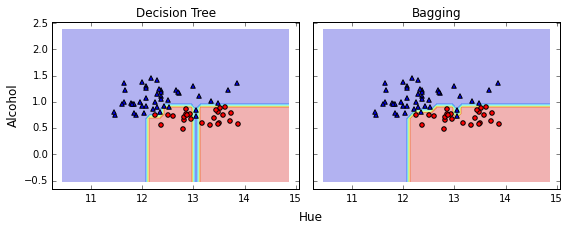

In [58]:
x_min = xtrain[:, 0].min() - 1
x_max = xtrain[:, 0].max() + 1
y_min = xtrain[:, 1].min() - 1
y_max = xtrain[:, 1].max() + 1

xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(nrows=1, ncols=2, 
                        sharex='col', 
                        sharey='row', 
                        figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, bag],
                        ['Decision Tree', 'Bagging']):
    clf.fit(xtrain, ytrain)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(xtrain[ytrain == 0, 0],
                       xtrain[ytrain == 0, 1],
                       c='blue', marker='^')

    axarr[idx].scatter(xtrain[ytrain == 1, 0],
                       xtrain[ytrain == 1, 1],
                       c='red', marker='o')

    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2,
         s='Hue',
         ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()

In [59]:
from sklearn.ensemble import AdaBoostClassifier

In [60]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=1)
ada = AdaBoostClassifier(base_estimator=tree, n_estimators=500, learning_rate=0.1, random_state=0)
tree = tree.fit(xtrain, ytrain)
tree_train = accuracy_score(ytrain, tree.predict(xtrain))
tree_test = accuracy_score(ytest, tree.predict(xtest))
print "Decision tree train/test accuracy %0.4f/%0.4f" %(tree_train, tree_test)

Decision tree train/test accuracy 0.8451/0.8542


In [61]:
ada = ada.fit(xtrain, ytrain)
ada_train = accuracy_score(ytrain, ada.predict(xtrain))
ada_test = accuracy_score(ytest, ada.predict(xtest))
print "Adaboost train/test accuracy %0.4f/%0.4f" %(ada_train, ada_test)

Adaboost train/test accuracy 1.0000/0.8750


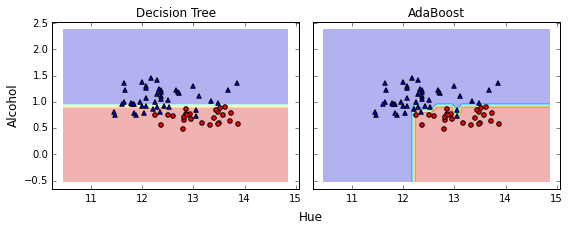

In [63]:
x_min, x_max = xtrain[:, 0].min() - 1, xtrain[:, 0].max() + 1
y_min, y_max = xtrain[:, 1].min() - 1, xtrain[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(1, 2, sharex='col', sharey='row', figsize=(8, 3))


for idx, clf, tt in zip([0, 1],
                        [tree, ada],
                        ['Decision Tree', 'AdaBoost']):
    clf.fit(xtrain, ytrain)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx].contourf(xx, yy, Z, alpha=0.3)
    axarr[idx].scatter(xtrain[ytrain == 0, 0],
                       xtrain[ytrain == 0, 1],
                       c='blue', marker='^')
    axarr[idx].scatter(xtrain[ytrain == 1, 0],
                       xtrain[ytrain == 1, 1],
                       c='red', marker='o')
    axarr[idx].set_title(tt)

axarr[0].set_ylabel('Alcohol', fontsize=12)
plt.text(10.2, -1.2,
         s='Hue',
         ha='center', va='center', fontsize=12)

plt.tight_layout()
plt.show()